In [2]:
import sys

sys.path.append('../src')

from bearing_dataset import BearingDataset

In [32]:
bearing_dataset = BearingDataset(type='A')
print('Loaded bearing dataset type ', bearing_dataset.get_type(), ' with ',
      bearing_dataset.get_cats_num(), ' categories, total ', len(bearing_dataset), ' samples')


Loaded bearing dataset type  A  with  4  categories, total  4738  samples


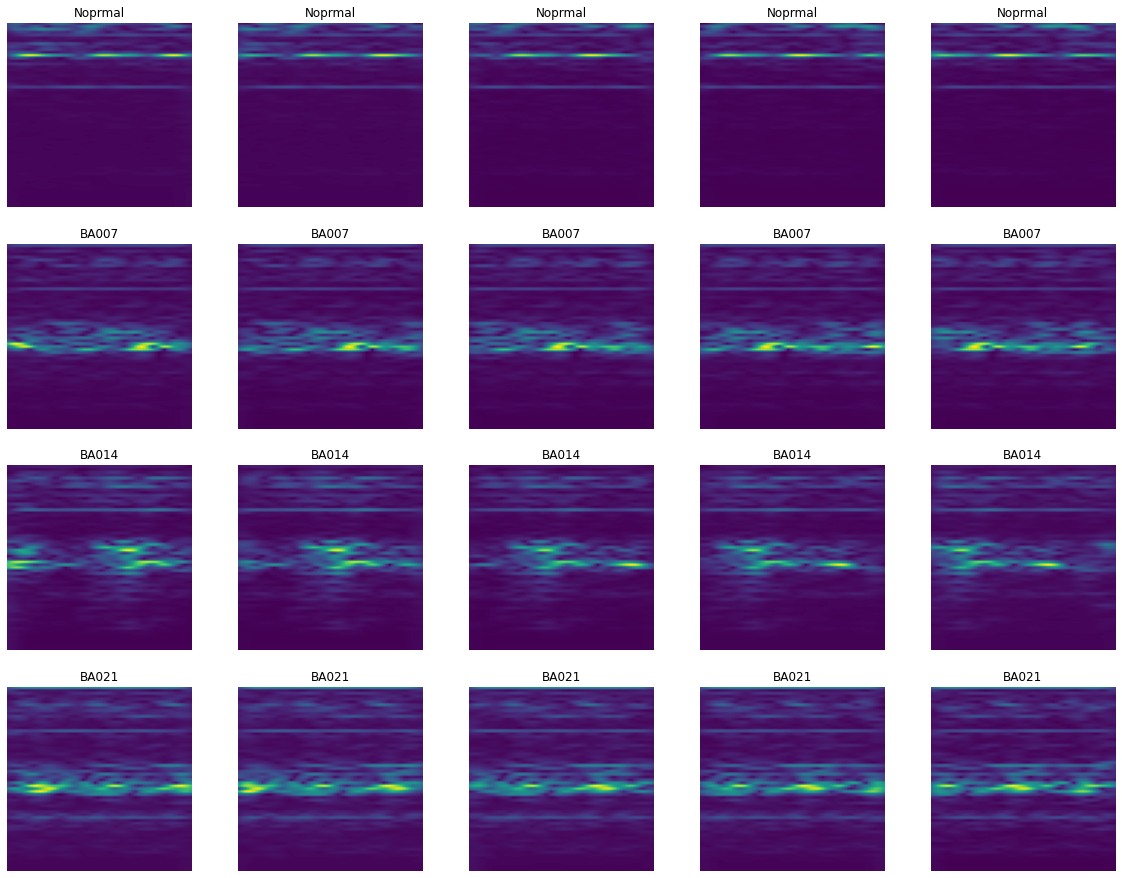

In [4]:
import matplotlib.pyplot as plt
import random

plt.figure(figsize=(20, 40))
index = 0
for lbl_idx in range(bearing_dataset.get_cats_num()):
    images = bearing_dataset.getimgs(lbl_idx)[:5]
    for img in images:
        plt.subplot(10, 5, index + 1)
        plt.imshow(img)
        plt.axis('off')
        plt.title(bearing_dataset.getlabel(lbl_idx))
        index = index + 1
        if index == 50: break
plt.show()

In [6]:
import torch
from catgan import Classifier, Generator

(64, 64)
torch.Size([1, 1, 64, 64])
tensor([[ 1.0380,  0.4764, -0.0883,  0.1883]], grad_fn=<AddmmBackward0>)


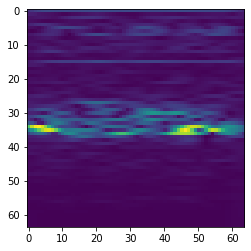

In [47]:
classifier = Classifier(cat_num = bearing_dataset.get_cats_num()).float()
img = bearing_dataset.getimgs(1)[0]
plt.imshow(img)
print (img.shape)
img = torch.unsqueeze(torch.from_numpy(img),0)
img = torch.unsqueeze(img,0).float()
print (img.shape)
latent = classifier(img)
print(latent)

In [10]:
from torch.utils.data import DataLoader

train_set, val_set = torch.utils.data.random_split(bearing_dataset, [len(bearing_dataset)*7//10, len(bearing_dataset)-len(bearing_dataset)*7//10])

train_loader = DataLoader(train_set, batch_size=30, shuffle=True, drop_last=True)
val_loader = DataLoader(val_set, batch_size=1, shuffle=False, drop_last=True)
len(train_loader), len(val_loader)

(110, 1422)

In [55]:
from tqdm.notebook import tqdm

device = f'cuda:{0}' if torch.cuda.is_available() else 'cpu'
print(device)
classifier = Classifier(cat_num = bearing_dataset.get_cats_num()).float().to(device)

optim = torch.optim.Adam(classifier.parameters(), lr=0.0001)

criterion = torch.nn.CrossEntropyLoss().to(device)

losses = []
classifier.train()

for epoch in range(100):
    for image, labelidx in tqdm(train_loader, desc = 'train loop', leave = True, disable = True):
        image = torch.unsqueeze(image,1).float()
        optim.zero_grad()
        image = image.to(device)
        out = classifier(image)
        target = torch.zeros(len(labelidx),bearing_dataset.get_cats_num())
        for idx, tv in enumerate(target):
            tv[labelidx[idx]]=1.
        loss = criterion(out, target.to(device))
        loss.backward()
        optim.step()
        losses.append(loss.item())
plt.plot(losses)
plt.show()


cuda:0


KeyboardInterrupt: 

torch.Size([30, 4])
tensor([[9.9997e-01, 1.0723e-05, 1.2107e-05, 1.1045e-05],
        [9.9993e-01, 3.7127e-05, 2.1770e-05, 1.0906e-05],
        [9.9963e-01, 1.2701e-04, 8.6328e-05, 1.5936e-04],
        [9.9997e-01, 6.4043e-06, 1.2917e-05, 1.5566e-05],
        [4.1846e-06, 1.3243e-06, 9.9999e-01, 6.9295e-06],
        [1.3958e-08, 6.5370e-08, 1.0000e+00, 1.9182e-07],
        [5.2053e-06, 1.0723e-04, 9.9984e-01, 4.2736e-05],
        [6.1814e-07, 1.5532e-06, 1.5727e-08, 1.0000e+00],
        [9.9990e-01, 7.1399e-05, 1.6227e-05, 1.0370e-05],
        [9.9988e-01, 4.6721e-05, 2.0668e-05, 5.0937e-05],
        [1.7456e-05, 9.9993e-01, 6.2941e-06, 4.5667e-05],
        [1.0715e-06, 9.9999e-01, 2.1374e-06, 4.3979e-06],
        [1.5480e-04, 4.8891e-04, 9.9899e-01, 3.6143e-04],
        [9.9987e-01, 6.4008e-05, 3.6665e-05, 2.7123e-05],
        [9.9976e-01, 1.3319e-04, 4.1298e-05, 6.3521e-05],
        [3.1942e-05, 9.9877e-01, 3.8863e-04, 8.0868e-04],
        [9.9989e-01, 3.7153e-05, 4.1991e-05, 3.5698e

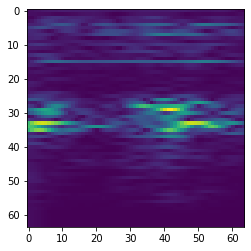

In [70]:
from torch.distributions import Categorical

for image, labelidx in tqdm(train_loader, desc = 'train loop', leave = True, disable = True):
        image = torch.unsqueeze(image,1).float()
        optim.zero_grad()
        image = image.to(device)
        out = classifier(image)
        print(out.shape)
        sm = torch.nn.Softmax(dim=1)
        print(sm(out))
        entropy2 = Categorical(probs = sm(out)).entropy()
        print(entropy2)
        entropy2 = Categorical(probs = sm(out)[0]).entropy()
        print(entropy2)
        break



img = bearing_dataset.getimgs(2)[0]
plt.imshow(img)
print (img.shape)
img = torch.unsqueeze(torch.from_numpy(img),0)
img = torch.unsqueeze(img,0).float()
print (img.shape)
latent = classifier(img.to(device))
print(latent)
sm = torch.nn.Softmax(dim=1)
print(sm(latent))
entropy2 = Categorical(probs = sm(latent)).entropy()
print(entropy2)
entropy2 = Categorical(probs = torch.Tensor([0., 0., 0., 1])).entropy()
print(entropy2)


torch.Size([1, 1, 64, 64])
(64, 64)
(64, 64)
944


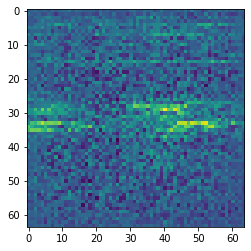

In [53]:
noise = torch.rand(1,200,1,1)
gen = Generator()
emb = gen(noise)

print(emb.shape)
emb = emb.squeeze(0).squeeze(0).detach().numpy()
print(emb.shape)
img = bearing_dataset.getimgs(2)[0]
print(img.shape)

#plt.imshow(img)
#plt.imshow(emb)
plt.imshow(img+emb/2)
min_samples = len(bearing_dataset.getimgs(0))
for i in range( bearing_dataset.get_cats_num()):
    min_samples = min(min_samples,len(bearing_dataset.getimgs(i)))
print(min_samples)



In [46]:
ct1 = torch.nn.ConvTranspose2d(200,200,3,stride=2)
ct2 = torch.nn.ConvTranspose2d(200,64,3,stride=2)
ct3 = torch.nn.ConvTranspose2d(64,32,3,stride=2)
ct4 = torch.nn.ConvTranspose2d(32,16,3,stride=2)
ct5 = torch.nn.ConvTranspose2d(16,1,4,stride=2)
t = torch.ones((1,1,1,200))
print (t.shape)
t=ct1(t.permute(0,3,1,2)).permute(0,2,3,1)
print(t.shape)
t=ct2(t.permute(0,3,1,2)).permute(0,2,3,1)
print(t.shape)
t=ct3(t.permute(0,3,1,2)).permute(0,2,3,1)
print(t.shape)
t=ct4(t.permute(0,3,1,2)).permute(0,2,3,1)
print(t.shape)
t=ct5(t.permute(0,3,1,2)).permute(0,2,3,1)
print(t.shape)


torch.Size([1, 1, 1, 200])
torch.Size([1, 3, 3, 200])
torch.Size([1, 7, 7, 64])
torch.Size([1, 15, 15, 32])
torch.Size([1, 31, 31, 16])
torch.Size([1, 64, 64, 1])
